<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP_AE/MLP_AE_Google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 7.57 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 15:38:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Google'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 7.4 MB/s 
     |████████████████████████████████| 133 kB 41.7 MB/s 
     |████████████████████████████████| 170 kB 42.6 MB/s 
     |████████████████████████████████| 97 kB 6.6 MB/s 
     |████████████████████████████████| 138 kB 35.6 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 62 kB 874 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(RepeatVector(window_len))
    # layer 7
    model.add(Dense(32, activation=config.activation))
    # layer 8
    model.add(Dense(64, activation=config.activation))
    # layer 9
    model.add(Dense(128, activation=config.activation))
    # layer 10
    model.add(Flatten())
    # layer 11
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: 3jmai25y
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP_AE/sweeps/3jmai25y


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: 14429dtr with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
31/31 [==============================] - 18s 41ms/step - loss: 1.0535 - mean_squared_error: 1.0535 - mean_absolute_error: 0.6036 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1408
Epoch 2/50
31/31 [==============================] - 0s 12ms/step - loss: 0.1121 - mean_squared_error: 0.1121 - mean_absolute_error: 0.1932 - val_loss: 0.0366 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1563
Epoch 3/50
31/31 [==============================] - 0s 12ms/step - loss: 0.1023 - mean_squared_error: 0.1023 - mean_absolute_error: 0.1739 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1328
Epoch 4/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0486 - mean_squared_error: 0.0486 - mean_absolute_error: 0.1181 - val_loss: 0.0321 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1428
Epoch 5/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0224 - mean_squared_erro

epoch,49
loss,0.00303
mean_squared_error,0.00303
mean_absolute_error,0.0413
val_loss,0.0073
val_mean_squared_error,0.0073
val_mean_absolute_error,0.06694
_runtime,44
_timestamp,1627054776
_step,49
best_val_loss,0.00714


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▃▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▄▃▃▃▃▂▄▂▃▂▃▂▂▂▁▂▁▂▂▂▂▂▁▂▁▂▂▁▁▂▁▂▁▂▁▁
val_loss,▁▁▁▁▁█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▂▁▁▂█▂▁▃▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: wp7fggeo with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 109ms/step - loss: 0.7929 - mean_squared_error: 0.7929 - mean_absolute_error: 0.7020 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1709
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 3.5724 - mean_squared_error: 3.5724 - mean_absolute_error: 1.0521 - val_loss: 5642.4790 - val_mean_squared_error: 5642.4790 - val_mean_absolute_error: 75.0074
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - v

epoch,10
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,7
_timestamp,1627054809
_step,10
best_val_loss,0.04499


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,▁█
mean_squared_error,▁█
mean_absolute_error,▁█
val_loss,▁█
val_mean_squared_error,▁█
val_mean_absolute_error,▁█
_runtime,▁▁▁▁███████
_timestamp,▁▁▁▁███████
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: qbh7kkdg with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 3s 113ms/step - loss: 3.2838 - mean_squared_error: 3.2838 - mean_absolute_error: 1.1878 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1384
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0537 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1368
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0315 - mean_squared_error: 0.0315 - mean_absolute_error: 0.0972 - val_loss: 0.0917 - val_mean_squared_error: 0.0917 - val_mean_absolute_error: 0.2667
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0208 - mean_squared_error: 0.0208 - mean_absolute_error: 0.1089 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1288
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0069 - mean_squared_error: 0.

epoch,18
loss,0.12903
mean_squared_error,0.12903
mean_absolute_error,0.2873
val_loss,0.02099
val_mean_squared_error,0.02099
val_mean_absolute_error,0.11956
_runtime,9
_timestamp,1627054826
_step,18
best_val_loss,0.01997


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▁▁▁▁▁▁▃▁▁▁▁▂▂▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▃▁▁▁▁▂▂▁▁▁▁▁
mean_absolute_error,█▁▂▁▁▁▃▆▁▁▂▁▄▄▁▁▁▂▃
val_loss,▁▁▂▁▁▁█▁▁▃▁▁▇▁▁▁▂▃▁
val_mean_squared_error,▁▁▂▁▁▁█▁▁▃▁▁▇▁▁▁▂▃▁
val_mean_absolute_error,▁▁▂▁▂▂█▁▁▄▁▂█▁▁▁▃▄▁
_runtime,▁▃▃▃▃▃▃▃▆▆▆▆▆▆█████
_timestamp,▁▃▃▃▃▃▃▃▆▆▆▆▆▆█████
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: 9kt7gjmj with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 4s 114ms/step - loss: 0.2006 - mean_squared_error: 0.2006 - mean_absolute_error: 0.3621 - val_loss: 0.0495 - val_mean_squared_error: 0.0495 - val_mean_absolute_error: 0.1780
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0306 - mean_squared_error: 0.0306 - mean_absolute_error: 0.1470 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1269
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0984 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1271
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0745 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1310
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0039 - mean_squared_error: 0.0039 

epoch,49
loss,0.0004
mean_squared_error,0.0004
mean_absolute_error,0.01505
val_loss,0.00772
val_mean_squared_error,0.00772
val_mean_absolute_error,0.0698
_runtime,16
_timestamp,1627054851
_step,49
best_val_loss,0.00702


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: cm81ykvo with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 5s 38ms/step - loss: 0.0680 - mean_squared_error: 0.0680 - mean_absolute_error: 0.1717 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1388
Epoch 2/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0493 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1190
Epoch 3/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0411 - val_loss: 0.0444 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1741
Epoch 4/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0502 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1108
Epoch 5/50
31/31 [==============================] - 0s 16ms/step - loss: 0.0028 - mean_squared_error

epoch,49
loss,0.00091
mean_squared_error,0.00091
mean_absolute_error,0.02177
val_loss,0.00796
val_mean_squared_error,0.00796
val_mean_absolute_error,0.07133
_runtime,34
_timestamp,1627054893
_step,49
best_val_loss,0.00716


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▁▂▁▁▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▂▁▁▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▂▃▂▂▃▃▂▃▂▂▂▂▂▁▁▃▂▂▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁
val_loss,▅▄█▃▃▄▂▂▂▂▄▂▂▃▁▂▁▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▃▂▁▂▁▁▁▁
val_mean_squared_error,▅▄█▃▃▄▂▂▂▂▄▂▂▃▁▂▁▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▃▂▁▂▁▁▁▁
val_mean_absolute_error,▆▄█▄▄▅▃▂▂▂▅▂▂▄▂▂▂▁▂▂▂▃▁▁▃▁▁▁▁▂▁▁▄▂▁▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: i5maxmed with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 60ms/step - loss: 0.6832 - mean_squared_error: 0.6832 - mean_absolute_error: 0.6020 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1136
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0264 - mean_squared_error: 0.0264 - mean_absolute_error: 0.1310 - val_loss: 0.0354 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1498
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0754 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1406
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0642 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0922
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0015 - mean_squared_error

epoch,28
loss,0.00177
mean_squared_error,0.00177
mean_absolute_error,0.03454
val_loss,0.00776
val_mean_squared_error,0.00776
val_mean_absolute_error,0.06839
_runtime,15
_timestamp,1627054928
_step,28
best_val_loss,0.00543


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_loss,▅█▇▃▂▂▂▁▂▂▁▁▂▁▂▁▁▁▁▁▁▁▂▂▂▁▁▂▂
val_mean_squared_error,▅█▇▃▂▂▂▁▂▂▁▁▂▁▂▁▁▁▁▁▁▁▂▂▂▁▁▂▂
val_mean_absolute_error,▅█▇▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▂▂▂▂▂▂
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: ih5p1pxz with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 60ms/step - loss: 138.4471 - mean_squared_error: 138.4471 - mean_absolute_error: 9.2399 - val_loss: 799.7454 - val_mean_squared_error: 799.7454 - val_mean_absolute_error: 24.3160
Epoch 2/50
16/16 [==============================] - 0s 13ms/step - loss: 198.5997 - mean_squared_error: 198.5997 - mean_absolute_error: 9.9210 - val_loss: 2.6453 - val_mean_squared_error: 2.6453 - val_mean_absolute_error: 1.4953
Epoch 3/50
16/16 [==============================] - 0s 18ms/step - loss: 11.7252 - mean_squared_error: 11.7252 - mean_absolute_error: 2.6646 - val_loss: 2.0055 - val_mean_squared_error: 2.0055 - val_mean_absolute_error: 1.4056
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 0.9863 - mean_squared_error: 0.9863 - mean_absolute_error: 0.9246 - val_loss: 0.7565 - val_mean_squared_error: 0.7565 - val_mean_absolute_error: 0.8461
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 0.9076 - mea

epoch,21
loss,0.29542
mean_squared_error,0.29542
mean_absolute_error,0.44708
val_loss,0.05843
val_mean_squared_error,0.05843
val_mean_absolute_error,0.20868
_runtime,13
_timestamp,1627054948
_step,21
best_val_loss,0.03141


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▆▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▂▁▂▃▂▃▂▁▁▂▂▁▂▂▂▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▁▁▁▁▂▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 25yp22m9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 3s 35ms/step - loss: 2.6939 - mean_squared_error: 2.6939 - mean_absolute_error: 0.7483 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1226
Epoch 2/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0486 - mean_squared_error: 0.0486 - mean_absolute_error: 0.1438 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1468
Epoch 3/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0185 - mean_squared_error: 0.0185 - mean_absolute_error: 0.0748 - val_loss: 0.0661 - val_mean_squared_error: 0.0661 - val_mean_absolute_error: 0.2131
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0891 - mean_squared_error: 0.0891 - mean_absolute_error: 0.1991 - val_loss: 0.1858 - val_mean_squared_error: 0.1858 - val_mean_absolute_error: 0.3857
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 0.2742 - mean_squared_

epoch,27
loss,0.02123
mean_squared_error,0.02123
mean_absolute_error,0.08475
val_loss,0.01136
val_mean_squared_error,0.01136
val_mean_absolute_error,0.08433
_runtime,18
_timestamp,1627054974
_step,27
best_val_loss,0.01051


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▄▄▁▃▂▃▁▂▃▁▂▂▁▂▂▁▁▁▂▁▁▁▁▂
val_loss,▁▂▃█▂▁▂▁▁▁▃▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▂▃█▂▁▂▁▁▁▃▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▃▄█▃▂▂▁▂▂▃▂▁▁▃▁▁▁▁▂▂▁▁▂▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: vgogrtl8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 3s 59ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_er

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,9
_timestamp,1627054991
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▁▁▁▅▅▅▅▅█
_timestamp,▁▁▁▁▅▅▅▅▅█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: j91hlv3h with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 4s 118ms/step - loss: 0.1394 - mean_squared_error: 0.1394 - mean_absolute_error: 0.2917 - val_loss: 0.0914 - val_mean_squared_error: 0.0914 - val_mean_absolute_error: 0.2476
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - mean_absolute_error: 0.1214 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1459
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0846 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1317
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0480 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1507
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0127 - mean_squared_error: 0.0127 

epoch,49
loss,0.00302
mean_squared_error,0.00302
mean_absolute_error,0.04207
val_loss,0.02227
val_mean_squared_error,0.02227
val_mean_absolute_error,0.11885
_runtime,15
_timestamp,1627055014
_step,49
best_val_loss,0.01191


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▃▃▃▂▂▃▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▂▁▂▁▂▁▂▁▂▁▁▂▁▁
val_loss,█▃▂▃▂▂▃▃▂▂▂▂▂▁▃▂▂▂▃▂▁▁▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▂▁▂
val_mean_squared_error,█▃▂▃▂▂▃▃▂▂▂▂▂▁▃▂▂▂▃▂▁▁▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▂▁▂
val_mean_absolute_error,█▃▃▄▃▃▃▃▃▂▂▃▂▂▄▂▃▂▃▂▂▂▂▁▁▁▁▂▂▁▁▃▁▁▁▁▂▂▁▂
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mbzbghu9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 4s 66ms/step - loss: 0.1357 - mean_squared_error: 0.1357 - mean_absolute_error: 0.2923 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1670
Epoch 2/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.1457 - val_loss: 0.0694 - val_mean_squared_error: 0.0694 - val_mean_absolute_error: 0.2195
Epoch 3/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0278 - mean_squared_error: 0.0278 - mean_absolute_error: 0.1264 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1295
Epoch 4/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0709 - val_loss: 0.0473 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1790
Epoch 5/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0122 - mean_squared_error

epoch,49
loss,0.00244
mean_squared_error,0.00244
mean_absolute_error,0.03795
val_loss,0.01124
val_mean_squared_error,0.01124
val_mean_absolute_error,0.08351
_runtime,24
_timestamp,1627055047
_step,49
best_val_loss,0.01026


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▃▂▂▂▁▂▂▂▂▂▂▂▂▁▂▁▁▂▂▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁
val_loss,▄▇▃▅▃▂▂▂▂▂▂▃█▂▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂▂▁▁
val_mean_squared_error,▄▇▃▅▃▂▂▂▂▂▂▃█▂▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂▂▁▁
val_mean_absolute_error,▅▇▃▅▃▃▃▂▂▃▃▃█▂▃▂▂▂▂▃▂▂▂▂▂▂▂▁▁▁▁▂▃▁▁▁▂▃▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: zmaetwiw with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 3s 34ms/step - loss: 0.1136 - mean_squared_error: 0.1136 - mean_absolute_error: 0.2585 - val_loss: 0.0260 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.1352
Epoch 2/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0666 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1196
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0338 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1187
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0306 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1165
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0017 - mean_squared_

epoch,99
loss,0.0005
mean_squared_error,0.0005
mean_absolute_error,0.0167
val_loss,0.00797
val_mean_squared_error,0.00797
val_mean_absolute_error,0.07104
_runtime,48
_timestamp,1627055104
_step,99
best_val_loss,0.00797


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: fyep4sql with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 62ms/step - loss: 16.6706 - mean_squared_error: 16.6706 - mean_absolute_error: 2.4033 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1387
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.1093 - mean_squared_error: 0.1093 - mean_absolute_error: 0.1682 - val_loss: 0.0535 - val_mean_squared_error: 0.0535 - val_mean_absolute_error: 0.1851
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0701 - val_loss: 0.0624 - val_mean_squared_error: 0.0624 - val_mean_absolute_error: 0.2015
Epoch 4/50
16/16 [==============================] - 0s 13ms/step - loss: 2.3883 - mean_squared_error: 2.3883 - mean_absolute_error: 0.8810 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1210
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0041 - mean_squared_err

epoch,13
loss,0.01038
mean_squared_error,0.01038
mean_absolute_error,0.0782
val_loss,0.02409
val_mean_squared_error,0.02409
val_mean_absolute_error,0.1274
_runtime,11
_timestamp,1627055163
_step,13
best_val_loss,0.0208


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▁▁▄▁▁▁▁▄▁▁▁▃▁
mean_squared_error,█▁▁▄▁▁▁▁▄▁▁▁▃▁
mean_absolute_error,█▂▁▆▁▂▃▁▇▁▂▁▆▁
val_loss,▁▁▁▁▁█▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁█▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▁▁▁▂█▁▂▁▁▁▁▁▁
_runtime,▁▁▁▃▃▃▃▆▆▆▆███
_timestamp,▁▁▁▃▃▃▃▆▆▆▆███
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: brkctbr8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 3s 36ms/step - loss: 0.0909 - mean_squared_error: 0.0909 - mean_absolute_error: 0.2397 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1185
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0561 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1078
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0314 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0891
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 9.1800e-04 - mean_squared_error: 9.1800e-04 - mean_absolute_error: 0.0234 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0801
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 7.9572e-04 - m

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,50
loss,0.00082
mean_squared_error,0.00082
mean_absolute_error,0.02159
val_loss,0.00505
val_mean_squared_error,0.00505
val_mean_absolute_error,0.05494
_runtime,32
_timestamp,1627055203
_step,50
best_val_loss,0.00491


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▃▃▄▂▂▂▂▃▂▂▂▂▂▁▂▄▄▁▂▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▄▃▃▄▂▂▂▂▃▂▂▂▂▂▁▂▄▄▁▂▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▄▃▄▃▃▂▂▃▂▂▂▃▂▂▂▅▄▂▂▁▂▂▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: m2bfcj08 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 63ms/step - loss: 34.8219 - mean_squared_error: 34.8219 - mean_absolute_error: 2.4402 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1315
Epoch 2/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0760 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1386
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.0996 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1372
Epoch 4/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0834 - val_loss: 0.0755 - val_mean_squared_error: 0.0755 - val_mean_absolute_error: 0.2275
Epoch 5/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0231 - mean_squared_err

epoch,49
loss,0.0039
mean_squared_error,0.0039
mean_absolute_error,0.04832
val_loss,0.01084
val_mean_squared_error,0.01084
val_mean_absolute_error,0.08287
_runtime,21
_timestamp,1627055248
_step,49
best_val_loss,0.01012


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▃▃█▆▂▃▂▆▂▂▂▅▅▂▆▅▄▃▃▂▁▁▁▅▄▁▂▃▁▁▄▁▂▂▁▁▁▁▁
val_mean_squared_error,▃▃▃█▆▂▃▂▆▂▂▂▅▅▂▆▅▄▃▃▂▁▁▁▅▄▁▂▃▁▁▄▁▂▂▁▁▁▁▁
val_mean_absolute_error,▃▄▄█▇▃▄▃▇▃▃▃▆▆▃▇▆▄▃▄▂▂▂▂▆▅▁▃▄▁▁▅▁▃▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: cm1fn88y with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 3s 36ms/step - loss: 1.4543 - mean_squared_error: 1.4543 - mean_absolute_error: 0.5987 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1389
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.1166 - mean_squared_error: 0.1166 - mean_absolute_error: 0.2243 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1226
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 0.1519 - mean_squared_error: 0.1519 - mean_absolute_error: 0.2192 - val_loss: 0.0542 - val_mean_squared_error: 0.0542 - val_mean_absolute_error: 0.1925
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0981 - mean_squared_error: 0.0981 - mean_absolute_error: 0.1988 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1358
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0346 - mean_squared_

epoch,25
loss,0.01474
mean_squared_error,0.01474
mean_absolute_error,0.08114
val_loss,0.02196
val_mean_squared_error,0.02196
val_mean_absolute_error,0.12038
_runtime,19
_timestamp,1627055283
_step,25
best_val_loss,0.01179


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▂▃▁▂▂▂▁▂▁▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁
mean_squared_error,█▂▂▃▁▂▂▂▁▂▁▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▆▃▅▃▄▃▄▂▄▃▄▁▃▃▁▃▁▂▂▂▂▁▂
val_loss,▂▁▂▂▂▁▂▆▁▁▁▁▃▁▂▁▁▂▂▂▃█▁▁▁▁
val_mean_squared_error,▂▁▂▂▂▁▂▆▁▁▁▁▃▁▂▁▁▂▂▂▃█▁▁▁▁
val_mean_absolute_error,▂▂▃▂▃▂▃▇▁▂▂▁▅▂▂▁▁▃▂▂▄█▁▂▁▂
_runtime,▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: zkzbxid5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 3s 59ms/step - loss: 0.2158 - mean_squared_error: 0.2158 - mean_absolute_error: 0.3760 - val_loss: 0.1542 - val_mean_squared_error: 0.1542 - val_mean_absolute_error: 0.3225
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.1113 - mean_squared_error: 0.1113 - mean_absolute_error: 0.2540 - val_loss: 0.0595 - val_mean_squared_error: 0.0595 - val_mean_absolute_error: 0.1936
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0544 - mean_squared_error: 0.0544 - mean_absolute_error: 0.1984 - val_loss: 0.0437 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1775
Epoch 4/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0517 - mean_squared_error: 0.0517 - mean_absolute_error: 0.1936 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1697
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0420 - mean_squared_error

epoch,49
loss,0.00126
mean_squared_error,0.00126
mean_absolute_error,0.02648
val_loss,0.01473
val_mean_squared_error,0.01473
val_mean_absolute_error,0.09881
_runtime,21
_timestamp,1627055319
_step,49
best_val_loss,0.01473


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: oampxepq with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 124ms/step - loss: 0.8002 - mean_squared_error: 0.8002 - mean_absolute_error: 0.7204 - val_loss: 0.0918 - val_mean_squared_error: 0.0918 - val_mean_absolute_error: 0.2556
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0959 - mean_squared_error: 0.0959 - mean_absolute_error: 0.2514 - val_loss: 0.1523 - val_mean_squared_error: 0.1523 - val_mean_absolute_error: 0.3476
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0652 - mean_squared_error: 0.0652 - mean_absolute_error: 0.1991 - val_loss: 0.0383 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1615
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1639 - val_loss: 0.0367 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1552
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0170 - mean_squared_error: 0.

epoch,25
loss,0.00162
mean_squared_error,0.00162
mean_absolute_error,0.0323
val_loss,0.01146
val_mean_squared_error,0.01146
val_mean_absolute_error,0.08293
_runtime,15
_timestamp,1627055350
_step,25
best_val_loss,0.01076


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▂▅▃▂▁▁▁▁▁▁
val_loss,▅█▂▂▂▂▂▃▁▁▁▁▁▁▁▁▇▅▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▂▂▂▂▂▃▁▁▁▁▁▁▁▁▇▅▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▃▃▂▂▃▄▂▁▁▁▁▁▁▁█▅▂▂▁▁▁▁▁▁
_runtime,▁▂▂▂▂▃▃▃▃▃▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▃▃▃▃▃▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 5lkjvrcu with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 5s 114ms/step - loss: 0.2047 - mean_squared_error: 0.2047 - mean_absolute_error: 0.3678 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1276
Epoch 2/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0674 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1158
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0485 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1132
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0340 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1108
Epoch 5/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0036 - mean_squared_error: 0.

epoch,99
loss,0.00138
mean_squared_error,0.00138
mean_absolute_error,0.02844
val_loss,0.00914
val_mean_squared_error,0.00914
val_mean_absolute_error,0.07675
_runtime,30
_timestamp,1627055391
_step,99
best_val_loss,0.00847


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▄▅▄▃▄▃▃▃▂▂▃▂▂▂▂▂▂▃▂▂▂▂▂▁▃▁▃▂▁▂▁▁▁▁▁
val_mean_squared_error,█▆▅▅▄▄▅▄▃▄▃▃▃▂▂▃▂▂▂▂▂▂▃▂▂▂▂▂▁▃▁▃▂▁▂▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▃▂▂▃▂▂▂▂▂▁▃▁▃▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: yqi3ydxh with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 5s 40ms/step - loss: 1.9805 - mean_squared_error: 1.9805 - mean_absolute_error: 0.8726 - val_loss: 0.2415 - val_mean_squared_error: 0.2415 - val_mean_absolute_error: 0.4192
Epoch 2/50
31/31 [==============================] - 1s 17ms/step - loss: 0.1433 - mean_squared_error: 0.1433 - mean_absolute_error: 0.2890 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1178
Epoch 3/50
31/31 [==============================] - 1s 18ms/step - loss: 0.0514 - mean_squared_error: 0.0514 - mean_absolute_error: 0.1687 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1308
Epoch 4/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0665 - mean_squared_error: 0.0665 - mean_absolute_error: 0.1888 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1129
Epoch 5/50
31/31 [==============================] - 1s 16ms/step - loss: 0.0025 - mean_squared_error

epoch,49
loss,0.00054
mean_squared_error,0.00054
mean_absolute_error,0.01758
val_loss,0.00554
val_mean_squared_error,0.00554
val_mean_absolute_error,0.05811
_runtime,37
_timestamp,1627055458
_step,49
best_val_loss,0.00522


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▆█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▆█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,▇▃▃▃▁▁▄▃▁▁▁▁▁▁▁▁▁▁▁▁▃█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁██▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: dfa05aaa with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 113ms/step - loss: 259.3505 - mean_squared_error: 259.3505 - mean_absolute_error: 10.4265 - val_loss: 122.1888 - val_mean_squared_error: 122.1888 - val_mean_absolute_error: 11.0492
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 107.0812 - mean_squared_error: 107.0812 - mean_absolute_error: 9.1295 - val_loss: 19.1952 - val_mean_squared_error: 19.1952 - val_mean_absolute_error: 3.8085
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 62.6025 - mean_squared_error: 62.6025 - mean_absolute_error: 6.1215 - val_loss: 13.8229 - val_mean_squared_error: 13.8229 - val_mean_absolute_error: 3.6709
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 4.9041 - mean_squared_error: 4.9041 - mean_absolute_error: 1.8185 - val_loss: 6.3147 - val_mean_squared_error: 6.3147 - val_mean_absolute_error: 2.4336
Epoch 5/100
8/8 [==============================] - 0s 22ms/step - loss: 5.6347 - me

epoch,19
loss,0.48694
mean_squared_error,0.48694
mean_absolute_error,0.57123
val_loss,0.32405
val_mean_squared_error,0.32405
val_mean_absolute_error,0.50085
_runtime,11
_timestamp,1627055491
_step,19
best_val_loss,0.07388


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▃▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁
val_loss,█▂▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▄▂▂▁▁▁▂▂▁▁▁▁▁▁▂▁
_runtime,▁▁▁▁▃▃▃▃▆▆▆▆▆▆██████
_timestamp,▁▁▁▁▃▃▃▃▆▆▆▆▆▆██████
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: xjtngg99 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 62ms/step - loss: 0.4558 - mean_squared_error: 0.4558 - mean_absolute_error: 0.4099 - val_loss: 0.0312 - val_mean_squared_error: 0.0312 - val_mean_absolute_error: 0.1449
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0791 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1085
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0513 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0978
Epoch 4/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0407 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0854
Epoch 5/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0012 - mean_squared_

epoch,36
loss,0.0007
mean_squared_error,0.0007
mean_absolute_error,0.02059
val_loss,0.00597
val_mean_squared_error,0.00597
val_mean_absolute_error,0.06006
_runtime,20
_timestamp,1627055522
_step,36
best_val_loss,0.00545


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁
val_mean_squared_error,█▅▄▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁
val_mean_absolute_error,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁▃▂▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: n8m2ho2b with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 3s 63ms/step - loss: 2.1417 - mean_squared_error: 2.1417 - mean_absolute_error: 0.9395 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1265
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0501 - mean_squared_error: 0.0501 - mean_absolute_error: 0.1421 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1076
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0730 - val_loss: 0.0418 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1668
Epoch 4/100
16/16 [==============================] - 0s 16ms/step - loss: 0.3179 - mean_squared_error: 0.3179 - mean_absolute_error: 0.3851 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1258
Epoch 5/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0115 - mean_squared_

epoch,18
loss,0.0019
mean_squared_error,0.0019
mean_absolute_error,0.0331
val_loss,0.04479
val_mean_squared_error,0.04479
val_mean_absolute_error,0.17475
_runtime,14
_timestamp,1627055546
_step,18
best_val_loss,0.01643


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▁▁▃▁▂▁▂▁▁▂▁▂▁▂▁▁▁▁
mean_squared_error,█▁▁▃▁▂▁▂▁▁▂▁▂▁▂▁▁▁▁
mean_absolute_error,█▃▂▅▂▅▂▄▁▂▄▁▄▂▃▁▁▃▁
val_loss,▂▁▃▁▃▂▁▇▁▃▅▁▁▁█▁▂▁▃
val_mean_squared_error,▂▁▃▁▃▂▁▇▁▃▅▁▁▁█▁▂▁▃
val_mean_absolute_error,▂▁▃▂▃▂▂▇▁▃▅▂▂▁█▁▂▁▄
_runtime,▁▂▂▂▂▄▄▄▅▅▅▅▇▇▇▇███
_timestamp,▁▂▂▂▂▄▄▄▅▅▅▅▇▇▇▇███
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: cwfk3lak with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 4s 67ms/step - loss: 0.1284 - mean_squared_error: 0.1284 - mean_absolute_error: 0.2684 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1252
Epoch 2/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0525 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1336
Epoch 3/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0464 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1219
Epoch 4/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0381 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1417
Epoch 5/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0045 - mean_squared_

epoch,99
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.01484
val_loss,0.0068
val_mean_squared_error,0.0068
val_mean_absolute_error,0.06594
_runtime,44
_timestamp,1627055601
_step,99
best_val_loss,0.0066


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▁▁▂▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▆▅▄▄▃▃▃▂▂▂▂▂█▂▂▂▁▁▂▂▁▂▁▂▂▁▃▂▁▁▁▁▂▁▁▁▁▁▂▁
val_mean_squared_error,▆▅▄▄▃▃▃▂▂▂▂▂█▂▂▂▁▁▂▂▁▂▁▂▂▁▃▂▁▁▁▁▂▁▁▁▁▁▂▁
val_mean_absolute_error,▆▆▅▅▃▄▃▃▂▂▂▂█▂▂▂▁▂▂▃▁▂▂▂▂▁▄▂▁▁▁▁▃▁▁▁▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: axcbjvxo with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 118ms/step - loss: 0.1885 - mean_squared_error: 0.1885 - mean_absolute_error: 0.3523 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1264
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0239 - mean_squared_error: 0.0239 - mean_absolute_error: 0.1385 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1275
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0984 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1189
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0677 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1177
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0033 - mean_squared_error: 0.

epoch,45
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.01473
val_loss,0.00723
val_mean_squared_error,0.00723
val_mean_absolute_error,0.06767
_runtime,19
_timestamp,1627055631
_step,45
best_val_loss,0.00704


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▆▆▆▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▆▆▆▆▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▇▆▇▅▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: 8pds713l with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 3s 63ms/step - loss: 0.1725 - mean_squared_error: 0.1725 - mean_absolute_error: 0.3281 - val_loss: 0.0507 - val_mean_squared_error: 0.0507 - val_mean_absolute_error: 0.1936
Epoch 2/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0598 - mean_squared_error: 0.0598 - mean_absolute_error: 0.2072 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1670
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - mean_absolute_error: 0.1486 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1319
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0618 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1282
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0026 - mean_squared_

epoch,99
loss,0.00064
mean_squared_error,0.00064
mean_absolute_error,0.01862
val_loss,0.00931
val_mean_squared_error,0.00931
val_mean_absolute_error,0.07776
_runtime,35
_timestamp,1627055676
_step,99
best_val_loss,0.00931


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: zxfmftpg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 3s 66ms/step - loss: 0.0767 - mean_squared_error: 0.0767 - mean_absolute_error: 0.1909 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1266
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0614 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1242
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0564 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1220
Epoch 4/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0578 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1305
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0083 - mean_squared_

epoch,62
loss,0.00173
mean_squared_error,0.00173
mean_absolute_error,0.03059
val_loss,0.00952
val_mean_squared_error,0.00952
val_mean_absolute_error,0.07749
_runtime,27
_timestamp,1627055714
_step,62
best_val_loss,0.00893


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▃▃▃▃█▂▄▂▂▂▂▂▂▂▂▂▁▁▂▁▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,▃▃▃▃█▂▄▂▂▂▂▂▂▂▂▂▁▁▂▁▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,▃▃▄▃█▃▄▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▃▁▁▁▃▁▁▁▁▁▁▂▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: xmp4key5 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 4s 122ms/step - loss: 2.9293 - mean_squared_error: 2.9293 - mean_absolute_error: 1.3036 - val_loss: 0.2096 - val_mean_squared_error: 0.2096 - val_mean_absolute_error: 0.4027
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0927 - mean_squared_error: 0.0927 - mean_absolute_error: 0.2352 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1308
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - mean_absolute_error: 0.0998 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1291
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0827 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1060
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0035 - mean_squared_error: 0.

epoch,35
loss,0.00068
mean_squared_error,0.00068
mean_absolute_error,0.01985
val_loss,0.006
val_mean_squared_error,0.006
val_mean_absolute_error,0.06081
_runtime,17
_timestamp,1627055743
_step,35
best_val_loss,0.00568


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: wwlos7fp with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 3s 119ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,10
_timestamp,1627055766
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▅▅▅▅▅▅▅██
_timestamp,▁▅▅▅▅▅▅▅██
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: ciufzvzh with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 118ms/step - loss: 0.4482 - mean_squared_error: 0.4482 - mean_absolute_error: 0.5063 - val_loss: 0.0537 - val_mean_squared_error: 0.0537 - val_mean_absolute_error: 0.1910
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0185 - mean_squared_error: 0.0185 - mean_absolute_error: 0.1047 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1495
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0586 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1140
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0403 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0917
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0014 - mean_squared_error: 0.

epoch,99
loss,0.00029
mean_squared_error,0.00029
mean_absolute_error,0.01241
val_loss,0.00487
val_mean_squared_error,0.00487
val_mean_absolute_error,0.05301
_runtime,28
_timestamp,1627055806
_step,99
best_val_loss,0.00487


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 62xxvf9o with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 3s 124ms/step - loss: 0.2141 - mean_squared_error: 0.2141 - mean_absolute_error: 0.3773 - val_loss: 0.2273 - val_mean_squared_error: 0.2273 - val_mean_absolute_error: 0.4141
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1789 - mean_squared_error: 0.1789 - mean_absolute_error: 0.3316 - val_loss: 0.1685 - val_mean_squared_error: 0.1685 - val_mean_absolute_error: 0.3393
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1374 - mean_squared_error: 0.1374 - mean_absolute_error: 0.2859 - val_loss: 0.1160 - val_mean_squared_error: 0.1160 - val_mean_absolute_error: 0.2681
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0894 - mean_squared_error: 0.0894 - mean_absolute_error: 0.2401 - val_loss: 0.0800 - val_mean_squared_error: 0.0800 - val_mean_absolute_error: 0.2212
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0675 - mean_squared_error: 0.0675 

epoch,49
loss,0.00179
mean_squared_error,0.00179
mean_absolute_error,0.03238
val_loss,0.01977
val_mean_squared_error,0.01977
val_mean_absolute_error,0.11693
_runtime,18
_timestamp,1627055836
_step,49
best_val_loss,0.01977


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▅▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▇▅▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rebtj651 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 5s 43ms/step - loss: 0.0813 - mean_squared_error: 0.0813 - mean_absolute_error: 0.1976 - val_loss: 0.0344 - val_mean_squared_error: 0.0344 - val_mean_absolute_error: 0.1507
Epoch 2/50
31/31 [==============================] - 1s 19ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0616 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1220
Epoch 3/50
31/31 [==============================] - 1s 21ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0362 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1503
Epoch 4/50
31/31 [==============================] - 1s 19ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0640 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1032
Epoch 5/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0025 - mean_squared_error

epoch,49
loss,0.00076
mean_squared_error,0.00076
mean_absolute_error,0.02033
val_loss,0.00831
val_mean_squared_error,0.00831
val_mean_absolute_error,0.07185
_runtime,42
_timestamp,1627055901
_step,49
best_val_loss,0.00613


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▃▂▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▃▂▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▅▃▂▂▂▃▂▃▂▂▂▂▁▁▂▂▂▁▁▂▂▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁
val_loss,█▅█▃▃█▃▂▂▃▆▂▂▂▂▂▂▁▃▁▁▂▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅█▃▃█▃▂▂▃▆▂▂▂▂▂▂▁▃▁▁▂▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▅▇▄▄█▃▃▃▃▇▂▃▂▃▂▂▂▄▂▂▂▁▂▂▂▂▂▁▂▁▃▁▁▁▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: ppx2ggz0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 3s 39ms/step - loss: 0.1461 - mean_squared_error: 0.1461 - mean_absolute_error: 0.2648 - val_loss: 0.0361 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1559
Epoch 2/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0536 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1191
Epoch 3/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0354 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1060
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0261 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0962
Epoch 5/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0016 - mean_squared_

epoch,40
loss,0.00091
mean_squared_error,0.00091
mean_absolute_error,0.02323
val_loss,0.00859
val_mean_squared_error,0.00859
val_mean_absolute_error,0.07337
_runtime,31
_timestamp,1627056022
_step,40
best_val_loss,0.00536


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁
val_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▂▂▁▂▂▃▂▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▃▂▁▂
val_mean_squared_error,█▅▄▃▃▃▂▂▂▂▂▁▁▂▂▁▂▂▃▂▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▃▂▁▂
val_mean_absolute_error,█▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▃▄▂▂▂▂▁▂▂▂▁▂▁▁▂▁▂▂▁▄▂▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: pdpx6hh2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 3s 120ms/step - loss: 6561.0535 - mean_squared_error: 6561.0535 - mean_absolute_error: 44.0078 - val_loss: 52.0480 - val_mean_squared_error: 52.0480 - val_mean_absolute_error: 6.8899
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 14.4699 - mean_squared_error: 14.4699 - mean_absolute_error: 2.7094 - val_loss: 2.1958 - val_mean_squared_error: 2.1958 - val_mean_absolute_error: 1.2478
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.9327 - mean_squared_error: 0.9327 - mean_absolute_error: 0.8204 - val_loss: 1.2196 - val_mean_squared_error: 1.2196 - val_mean_absolute_error: 0.8723
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 0.4901 - mean_squared_error: 0.4901 - mean_absolute_error: 0.5875 - val_loss: 1.0048 - val_mean_squared_error: 1.0048 - val_mean_absolute_error: 0.7287
Epoch 5/50
8/8 [==============================] - 0s 20ms/step - loss: 43.2428 - mean_squared_er

epoch,22
loss,0.28672
mean_squared_error,0.28672
mean_absolute_error,0.46199
val_loss,1.61103
val_mean_squared_error,1.61103
val_mean_absolute_error,1.20659
_runtime,13
_timestamp,1627056046
_step,22
best_val_loss,0.21977


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,▆▁▁▁▁▁▁▁█▁▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_squared_error,▆▁▁▁▁▁▁▁█▁▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_absolute_error,▇▁▁▁▂▂▁▂█▁▁▂▁▁▃▂▁▂▁▁▃▂▁
val_loss,▁▁▁▁▂▁▁▅▁▁▁▁▁▁█▁▁▁▁▂▄▁▁
val_mean_squared_error,▁▁▁▁▂▁▁▅▁▁▁▁▁▁█▁▁▁▁▂▄▁▁
val_mean_absolute_error,▂▁▁▁▃▁▂▆▂▁▁▂▁▂█▁▁▁▁▄▆▁▁
_runtime,▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
_timestamp,▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 59qi1xlg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 69ms/step - loss: 16.7534 - mean_squared_error: 16.7534 - mean_absolute_error: 1.7561 - val_loss: 0.1262 - val_mean_squared_error: 0.1262 - val_mean_absolute_error: 0.3171
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0394 - mean_squared_error: 0.0394 - mean_absolute_error: 0.1571 - val_loss: 0.0767 - val_mean_squared_error: 0.0767 - val_mean_absolute_error: 0.2322
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1053 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1216
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - mean_absolute_error: 0.1254 - val_loss: 0.0867 - val_mean_squared_error: 0.0867 - val_mean_absolute_error: 0.2534
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0456 - mean_squared_err

epoch,12
loss,0.0223
mean_squared_error,0.0223
mean_absolute_error,0.11102
val_loss,0.06097
val_mean_squared_error,0.06097
val_mean_absolute_error,0.21677
_runtime,12
_timestamp,1627056072
_step,12
best_val_loss,0.02176


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,█▅▁▅▁▁▇▂▂▂▂▃▄
val_mean_squared_error,█▅▁▅▁▁▇▂▂▂▂▃▄
val_mean_absolute_error,█▅▁▆▁▂▇▂▂▂▃▃▄
_runtime,▁▁▁▃▃▃▆▆▆▆███
_timestamp,▁▁▁▃▃▃▆▆▆▆███
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Agent Starting Run: 0x12o9p0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 66ms/step - loss: 0.1212 - mean_squared_error: 0.1212 - mean_absolute_error: 0.2607 - val_loss: 0.0416 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1683
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0798 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1294
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0431 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1329
Epoch 4/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0404 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1179
Epoch 5/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0018 - mean_squared_

epoch,99
loss,0.00069
mean_squared_error,0.00069
mean_absolute_error,0.02001
val_loss,0.00505
val_mean_squared_error,0.00505
val_mean_absolute_error,0.0563
_runtime,40
_timestamp,1627056125
_step,99
best_val_loss,0.00483


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▃▃▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▂▁▁▂▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2lj7vm6i with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 62ms/step - loss: 130.9045 - mean_squared_error: 130.9045 - mean_absolute_error: 8.5745 - val_loss: 172.4627 - val_mean_squared_error: 172.4627 - val_mean_absolute_error: 12.4685
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 41.2174 - mean_squared_error: 41.2174 - mean_absolute_error: 4.6230 - val_loss: 15.8918 - val_mean_squared_error: 15.8918 - val_mean_absolute_error: 3.6754
Epoch 3/100
16/16 [==============================] - 0s 18ms/step - loss: 10.1806 - mean_squared_error: 10.1806 - mean_absolute_error: 2.7495 - val_loss: 9.4341 - val_mean_squared_error: 9.4341 - val_mean_absolute_error: 3.0662
Epoch 4/100
16/16 [==============================] - 0s 21ms/step - loss: 7.5523 - mean_squared_error: 7.5523 - mean_absolute_error: 2.2544 - val_loss: 1.7673 - val_mean_squared_error: 1.7673 - val_mean_absolute_error: 1.0143
Epoch 5/100
16/16 [==============================] - 0s 17ms/step - loss: 12.0765

epoch,29
loss,0.11545
mean_squared_error,0.11545
mean_absolute_error,0.27651
val_loss,0.0586
val_mean_squared_error,0.0586
val_mean_absolute_error,0.20906
_runtime,19
_timestamp,1627056165
_step,29
best_val_loss,0.0563


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▂▁▁▁▁▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▃▃▃▂▂▃▃▂▃▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▁▂▁▃▃▂▂▁▂▂▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇███
_timestamp,▁▁▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: leqip2hd with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 122ms/step - loss: 0.1699 - mean_squared_error: 0.1699 - mean_absolute_error: 0.3280 - val_loss: 0.0715 - val_mean_squared_error: 0.0715 - val_mean_absolute_error: 0.2295
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.1672 - val_loss: 0.0349 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1502
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - mean_absolute_error: 0.0975 - val_loss: 0.0352 - val_mean_squared_error: 0.0352 - val_mean_absolute_error: 0.1545
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0749 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1217
Epoch 5/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0036 - mean_squared_error: 0.

epoch,99
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.01481
val_loss,0.00514
val_mean_squared_error,0.00514
val_mean_absolute_error,0.05691
_runtime,30
_timestamp,1627056215
_step,99
best_val_loss,0.00503


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cpnf3bwe with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 4s 70ms/step - loss: 0.3067 - mean_squared_error: 0.3067 - mean_absolute_error: 0.3579 - val_loss: 0.0496 - val_mean_squared_error: 0.0496 - val_mean_absolute_error: 0.1785
Epoch 2/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0509 - mean_squared_error: 0.0509 - mean_absolute_error: 0.1738 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1294
Epoch 3/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0600 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1208
Epoch 4/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0804 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1245
Epoch 5/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0073 - mean_squared_

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,68
loss,0.07272
mean_squared_error,0.07272
mean_absolute_error,0.2279
val_loss,0.06017
val_mean_squared_error,0.06017
val_mean_absolute_error,0.20186
_runtime,36
_timestamp,1627056283
_step,68
best_val_loss,0.00819


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▄
mean_squared_error,█▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▄
mean_absolute_error,█▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▆▇▇
val_loss,▄▂▂▂▂▂▂█▂▂▂▂▁▁▁▂▃▁▁▁▁▂▅▁▁▁▃▁▁▁▁▁▁▁▁▁▁▇▆▅
val_mean_squared_error,▄▂▂▂▂▂▂█▂▂▂▂▁▁▁▂▃▁▁▁▁▂▅▁▁▁▃▁▁▁▁▁▁▁▁▁▁▇▆▅
val_mean_absolute_error,▅▃▃▂▃▃▂█▂▂▂▂▂▂▂▂▄▁▁▁▁▃▆▁▁▁▃▂▁▁▁▁▁▁▁▁▁▆▆▆
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6b1116k3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 4s 56ms/step - loss: 0.0458 - mean_squared_error: 0.0458 - mean_absolute_error: 0.1501 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1182
Epoch 2/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0338 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1069
Epoch 3/100
31/31 [==============================] - 1s 17ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0510 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0871
Epoch 4/100
31/31 [==============================] - 1s 17ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0317 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0846
Epoch 5/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0013 - mean_squared_

epoch,48
loss,0.00047
mean_squared_error,0.00047
mean_absolute_error,0.01666
val_loss,0.00699
val_mean_squared_error,0.00699
val_mean_absolute_error,0.06496
_runtime,36
_timestamp,1627056342
_step,48
best_val_loss,0.00562


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▂▂▂▂▃▂▂▃▂▂▂▁▂▁▂▂▂▂▂▁▂▁▁▂▃▂▁▂▁▁▁▁▂▂▂▂▁
val_loss,█▇▄▄▃▃▃▃▂▂▂▂▂▁▂▂▁▂▂▂▂▂▂▁▁▁▂▄▂▁▂▁▁▁▂▂▅▁▂▂
val_mean_squared_error,█▇▄▄▃▃▃▃▂▂▂▂▂▁▂▂▁▂▂▂▂▂▂▁▁▁▂▄▂▁▂▁▁▁▂▂▅▁▂▂
val_mean_absolute_error,█▇▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▃▂▂▂▁▂▁▂▄▂▁▂▁▁▁▂▂▆▂▂▂
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: q3cf8g3n with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 4s 39ms/step - loss: 0.3076 - mean_squared_error: 0.3076 - mean_absolute_error: 0.2940 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1053
Epoch 2/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0331 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0851
Epoch 3/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0303 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0837
Epoch 4/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0333 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0828
Epoch 5/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0012 - mean_squared_

epoch,24
loss,0.00123
mean_squared_error,0.00123
mean_absolute_error,0.02788
val_loss,0.00563
val_mean_squared_error,0.00563
val_mean_absolute_error,0.05846
_runtime,23
_timestamp,1627056391
_step,24
best_val_loss,0.00514


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▂
val_loss,█▄▄▄▄▂▃▂▂▂▂▂▂▁▁▁▁▁▂▂▁▂▁▁▁
val_mean_squared_error,█▄▄▄▄▂▃▂▂▂▂▂▂▁▁▁▁▁▂▂▁▂▁▁▁
val_mean_absolute_error,█▅▅▅▄▃▃▂▃▂▂▂▂▂▁▂▂▁▂▂▂▂▁▁▁
_runtime,▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█
_timestamp,▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 5z50yj9k with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 4s 129ms/step - loss: 0.1493 - mean_squared_error: 0.1493 - mean_absolute_error: 0.2948 - val_loss: 0.0487 - val_mean_squared_error: 0.0487 - val_mean_absolute_error: 0.1791
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0965 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1412
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0887 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1201
Epoch 4/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0407 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1233
Epoch 5/50
8/8 [==============================] - 0s 26ms/step - loss: 0.0062 - mean_squared_error: 0.0062 

epoch,34
loss,0.00322
mean_squared_error,0.00322
mean_absolute_error,0.04391
val_loss,0.0183
val_mean_squared_error,0.0183
val_mean_absolute_error,0.10657
_runtime,19
_timestamp,1627056426
_step,34
best_val_loss,0.01325


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▃▁▂▃▂▂▂▂▃▂▂▁▂▃▂▁▂▃▂▂▁▂▂▁▁▂▁▁▂▁▂
val_loss,█▄▃▃▂▂▃▂▂▂▂▃▂▂▂▂▃▂▁▁▃▃▁▁▁▁▁▁▁▁▁▁▂▁▂
val_mean_squared_error,█▄▃▃▂▂▃▂▂▂▂▃▂▂▂▂▃▂▁▁▃▃▁▁▁▁▁▁▁▁▁▁▂▁▂
val_mean_absolute_error,█▅▃▃▃▂▄▂▃▂▂▃▂▂▂▂▃▂▁▁▃▃▂▁▁▁▁▁▁▁▁▁▂▁▂
_runtime,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: zri0v5s4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 121ms/step - loss: 0.3038 - mean_squared_error: 0.3038 - mean_absolute_error: 0.4222 - val_loss: 0.1256 - val_mean_squared_error: 0.1256 - val_mean_absolute_error: 0.2976
Epoch 2/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0763 - mean_squared_error: 0.0763 - mean_absolute_error: 0.2229 - val_loss: 0.1523 - val_mean_squared_error: 0.1523 - val_mean_absolute_error: 0.3440
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0619 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1976 - val_loss: 0.0784 - val_mean_squared_error: 0.0784 - val_mean_absolute_error: 0.2311
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0378 - mean_squared_error: 0.0378 - mean_absolute_error: 0.1488 - val_loss: 0.0332 - val_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.1472
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0188 - mean_squared_error: 0.

epoch,43
loss,0.00127
mean_squared_error,0.00127
mean_absolute_error,0.02684
val_loss,0.00976
val_mean_squared_error,0.00976
val_mean_absolute_error,0.08027
_runtime,20
_timestamp,1627056461
_step,43
best_val_loss,0.00846


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▅▃▂▁
mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▅▃▂▁
mean_absolute_error,█▅▄▃▃▃▃▂▂▁▂▂▆▅▄▂▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▇▇▄▄▁
val_loss,▇█▄▂▂▂▂▂▂▂▁▂▃▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▂▁
val_mean_squared_error,▇█▄▂▂▂▂▂▂▂▁▂▃▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▂▁
val_mean_absolute_error,▇█▅▃▃▃▂▂▂▂▂▂▅▅▃▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▃▃▄▃▁
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: m38b6pe9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 5s 206ms/step - loss: 0.8272 - mean_squared_error: 0.8272 - mean_absolute_error: 0.5445 - val_loss: 0.1933 - val_mean_squared_error: 0.1933 - val_mean_absolute_error: 0.3765
Epoch 2/50
8/8 [==============================] - 0s 26ms/step - loss: 0.1353 - mean_squared_error: 0.1353 - mean_absolute_error: 0.2708 - val_loss: 0.0584 - val_mean_squared_error: 0.0584 - val_mean_absolute_error: 0.1921
Epoch 3/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0487 - mean_squared_error: 0.0487 - mean_absolute_error: 0.1801 - val_loss: 0.1460 - val_mean_squared_error: 0.1460 - val_mean_absolute_error: 0.3102
Epoch 4/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0747 - mean_squared_error: 0.0747 - mean_absolute_error: 0.2084 - val_loss: 0.1091 - val_mean_squared_error: 0.1091 - val_mean_absolute_error: 0.2861
Epoch 5/50
8/8 [==============================] - 0s 25ms/step - loss: 0.0762 - mean_squared_error: 0.0762 

epoch,49
loss,0.0046
mean_squared_error,0.0046
mean_absolute_error,0.05442
val_loss,0.01143
val_mean_squared_error,0.01143
val_mean_absolute_error,0.08591
_runtime,24
_timestamp,1627056500
_step,49
best_val_loss,0.0101


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▂▁▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁
val_loss,█▃▆▅▁▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▆▅▁▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▆▆▂▂▂▂▂▂▂▂▂▂▂▃▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 4ti0iuel with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 4s 41ms/step - loss: 1.0172 - mean_squared_error: 1.0172 - mean_absolute_error: 0.5868 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1207
Epoch 2/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0846 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0914
Epoch 3/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0285 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0827
Epoch 4/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0270 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0784
Epoch 5/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0011 - mean_squared_

epoch,35
loss,0.00079
mean_squared_error,0.00079
mean_absolute_error,0.02123
val_loss,0.0093
val_mean_squared_error,0.0093
val_mean_absolute_error,0.07549
_runtime,30
_timestamp,1627056551
_step,35
best_val_loss,0.00501


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▂▁▁
val_loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▂▂▁▁▁
val_mean_squared_error,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▂▂▁▁▁
val_mean_absolute_error,▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂█▂▂▂▂▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: uyh71s1n with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 3s 121ms/step - loss: 0.1874 - mean_squared_error: 0.1874 - mean_absolute_error: 0.3461 - val_loss: 0.0757 - val_mean_squared_error: 0.0757 - val_mean_absolute_error: 0.2155
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0651 - mean_squared_error: 0.0651 - mean_absolute_error: 0.2145 - val_loss: 0.0461 - val_mean_squared_error: 0.0461 - val_mean_absolute_error: 0.1842
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - mean_absolute_error: 0.2001 - val_loss: 0.0440 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1714
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1743 - val_loss: 0.0317 - val_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.1491
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0267 - mean_squared_error: 0.

epoch,99
loss,0.00082
mean_squared_error,0.00082
mean_absolute_error,0.02101
val_loss,0.01099
val_mean_squared_error,0.01099
val_mean_absolute_error,0.0842
_runtime,29
_timestamp,1627056594
_step,99
best_val_loss,0.01099


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: x325jqqd with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 3s 120ms/step - loss: 2.3993 - mean_squared_error: 2.3993 - mean_absolute_error: 1.2110 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1536
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0567 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1383
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0518 - val_loss: 0.0725 - val_mean_squared_error: 0.0725 - val_mean_absolute_error: 0.2206
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0565 - mean_squared_error: 0.0565 - mean_absolute_error: 0.1964 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1139
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0123 - mean_squared_error: 0.0123 

epoch,13
loss,0.00371
mean_squared_error,0.00371
mean_absolute_error,0.04569
val_loss,0.05225
val_mean_squared_error,0.05225
val_mean_absolute_error,0.18327
_runtime,12
_timestamp,1627056640
_step,13
best_val_loss,0.01893


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▁▁▁▁▁▄▁▁▁▂▁▁▁
mean_squared_error,█▁▁▁▁▁▄▁▁▁▂▁▁▁
mean_absolute_error,█▁▁▂▂▃▅▁▁▂▅▂▁▁
val_loss,▁▁▁▁▁█▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁█▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▁▁▁▁█▁▁▁▂▁▁▁▁
_runtime,▁▁▁▅▅▅▅▅██████
_timestamp,▁▁▁▅▅▅▅▅██████
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: 8e5nfveg with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 3s 63ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/100
16/16 [==============================] - 0s 16ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
16/16 [==============================] - 0s 18ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
16/16 [==============================] - 0s 18ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_er

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,13
_timestamp,1627056667
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▁▃▃▃▃▆▆▆█
_timestamp,▁▁▃▃▃▃▆▆▆█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 2nxsy5tm with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 3s 121ms/step - loss: 0.0292 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1334 - val_loss: 0.0579 - val_mean_squared_error: 0.0579 - val_mean_absolute_error: 0.2000
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0735 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1734
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0549 - val_loss: 0.0344 - val_mean_squared_error: 0.0344 - val_mean_absolute_error: 0.1513
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0494 - val_loss: 0.0307 - val_mean_squared_error: 0.0307 - val_mean_absolute_error: 0.1400
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0031 - mean_squared_error: 0.0031 

epoch,49
loss,0.00068
mean_squared_error,0.00068
mean_absolute_error,0.01976
val_loss,0.00965
val_mean_squared_error,0.00965
val_mean_absolute_error,0.07696
_runtime,19
_timestamp,1627056700
_step,49
best_val_loss,0.00965


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: dv1f8ldp with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 3s 38ms/step - loss: 2.1182 - mean_squared_error: 2.1182 - mean_absolute_error: 0.7312 - val_loss: 0.0707 - val_mean_squared_error: 0.0707 - val_mean_absolute_error: 0.2242
Epoch 2/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0585 - mean_squared_error: 0.0585 - mean_absolute_error: 0.1831 - val_loss: 0.0345 - val_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.1499
Epoch 3/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.0779 - val_loss: 0.0947 - val_mean_squared_error: 0.0947 - val_mean_absolute_error: 0.2584
Epoch 4/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0728 - mean_squared_error: 0.0728 - mean_absolute_error: 0.1651 - val_loss: 0.0767 - val_mean_squared_error: 0.0767 - val_mean_absolute_error: 0.2399
Epoch 5/50
31/31 [==============================] - 0s 15ms/step - loss: 0.1014 - mean_squared_error

epoch,49
loss,0.00322
mean_squared_error,0.00322
mean_absolute_error,0.03893
val_loss,0.01186
val_mean_squared_error,0.01186
val_mean_absolute_error,0.08764
_runtime,37
_timestamp,1627056752
_step,49
best_val_loss,0.00731


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▄▃▄▂▃▃▄▁▃▂▃▂▂▁▂▁▂▂▂▂▁▂▂▁▂▁▂▂▁▂▂▁▁▁▂▁
val_loss,▂▁▂▂▂▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁
val_mean_squared_error,▂▁▂▂▂▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁
val_mean_absolute_error,▃▂▃▃▂▂▁▁█▃▂▂▁▁▂▁▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▅▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: qtbmjqrw with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 3s 65ms/step - loss: 0.0376 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1321 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1106
Epoch 2/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0424 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1058
Epoch 3/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0311 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1029
Epoch 4/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0281 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0995
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0012 - mean_squared_

epoch,99
loss,0.0004
mean_squared_error,0.0004
mean_absolute_error,0.01517
val_loss,0.00701
val_mean_squared_error,0.00701
val_mean_absolute_error,0.06401
_runtime,41
_timestamp,1627056821
_step,99
best_val_loss,0.00691


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: gzh9rpzg with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 3s 62ms/step - loss: 0.0574 - mean_squared_error: 0.0574 - mean_absolute_error: 0.1773 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0998
Epoch 2/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0351 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1090
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0747 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0935
Epoch 4/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0261 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0929
Epoch 5/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0011 - mean_squared_

epoch,99
loss,0.00037
mean_squared_error,0.00037
mean_absolute_error,0.01406
val_loss,0.0055
val_mean_squared_error,0.0055
val_mean_absolute_error,0.06024
_runtime,40
_timestamp,1627056876
_step,99
best_val_loss,0.00527


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▄▄▃▃▂▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▄▄▃▃▂▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: c278j4lq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 5s 46ms/step - loss: 0.1239 - mean_squared_error: 0.1239 - mean_absolute_error: 0.2491 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1203
Epoch 2/100
31/31 [==============================] - 1s 22ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0363 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1089
Epoch 3/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0376 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1018
Epoch 4/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0379 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0959
Epoch 5/100
31/31 [==============================] - 1s 21ms/step - loss: 0.0018 - mean_squared_

epoch,66
loss,0.00037
mean_squared_error,0.00037
mean_absolute_error,0.01436
val_loss,0.00784
val_mean_squared_error,0.00784
val_mean_absolute_error,0.06979
_runtime,58
_timestamp,1627056949
_step,66
best_val_loss,0.00669


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▆▄▄▃▅▃▃▂▃▄▂▂▃▄▃▃▂▂▃▁▁▁▂▂▁▂▁▂▁▂▁▂▁▁▁▁▁
val_mean_squared_error,█▆▄▆▄▄▃▅▃▃▂▃▄▂▂▃▄▃▃▂▂▃▁▁▁▂▂▁▂▁▂▁▂▁▂▁▁▁▁▁
val_mean_absolute_error,█▇▅▆▄▄▃▅▄▃▃▃▄▂▂▃▄▃▃▂▂▃▁▁▂▂▂▁▂▁▂▁▂▁▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: b1c85r3q with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 4s 132ms/step - loss: 0.6792 - mean_squared_error: 0.6792 - mean_absolute_error: 0.5660 - val_loss: 0.1953 - val_mean_squared_error: 0.1953 - val_mean_absolute_error: 0.3879
Epoch 2/50
8/8 [==============================] - 0s 27ms/step - loss: 0.0992 - mean_squared_error: 0.0992 - mean_absolute_error: 0.2481 - val_loss: 0.0560 - val_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.1940
Epoch 3/50
8/8 [==============================] - 0s 30ms/step - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.1484 - val_loss: 0.0717 - val_mean_squared_error: 0.0717 - val_mean_absolute_error: 0.2213
Epoch 4/50
8/8 [==============================] - 0s 25ms/step - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.1532 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1342
Epoch 5/50
8/8 [==============================] - 0s 25ms/step - loss: 0.0119 - mean_squared_error: 0.0119 

epoch,23
loss,0.00269
mean_squared_error,0.00269
mean_absolute_error,0.03818
val_loss,0.0197
val_mean_squared_error,0.0197
val_mean_absolute_error,0.11244
_runtime,17
_timestamp,1627057010
_step,23
best_val_loss,0.01113


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▂▂▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▂▂▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▆▃▃▂▁▁▁
val_loss,█▃▃▂▁▂▂▁▁▁▁▁▁▁▁▁▂▁▃▂▁▁▁▁
val_mean_squared_error,█▃▃▂▁▂▂▁▁▁▁▁▁▁▁▁▂▁▃▂▁▁▁▁
val_mean_absolute_error,█▄▄▂▂▂▃▂▂▁▁▁▁▁▁▁▂▁▄▂▂▂▁▂
_runtime,▁▁▁▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇▇████
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: 5j7q7zj2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 5s 138ms/step - loss: 0.1291 - mean_squared_error: 0.1291 - mean_absolute_error: 0.2679 - val_loss: 0.0368 - val_mean_squared_error: 0.0368 - val_mean_absolute_error: 0.1573
Epoch 2/50
8/8 [==============================] - 0s 31ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0960 - val_loss: 0.0277 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.1361
Epoch 3/50
8/8 [==============================] - 0s 27ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0532 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1420
Epoch 4/50
8/8 [==============================] - 0s 26ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0745 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1260
Epoch 5/50
8/8 [==============================] - 0s 28ms/step - loss: 0.0038 - mean_squared_error: 0.0038 

epoch,49
loss,0.00075
mean_squared_error,0.00075
mean_absolute_error,0.02048
val_loss,0.01055
val_mean_squared_error,0.01055
val_mean_absolute_error,0.08127
_runtime,24
_timestamp,1627057048
_step,49
best_val_loss,0.01055


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▂▁▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▃▂▃▂▃▂▂▁▂▂▃▂▁▂▂▂▂▁▂▂▁▂▂▁▁▂▂▁▁▁▁▁▂▃▁
val_loss,█▆▆▄▆▅▆▄▆▅▄▄▃▃▅▆▃▂▃▃▂▂▂▃▂▂▂▂▂▂▄▃▂▂▂▃▂▄▃▁
val_mean_squared_error,█▆▆▄▆▅▆▄▆▅▄▄▃▃▅▆▃▂▃▃▂▂▂▃▂▂▂▂▂▂▄▃▂▂▂▃▂▄▃▁
val_mean_absolute_error,█▆▇▅▆▅▆▄▆▆▄▄▃▄▅▆▃▂▃▃▃▂▂▃▂▂▃▂▂▂▄▄▂▂▂▃▂▄▃▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: den60j55 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 5s 44ms/step - loss: 151.9327 - mean_squared_error: 151.9327 - mean_absolute_error: 8.4988 - val_loss: 122.2234 - val_mean_squared_error: 122.2234 - val_mean_absolute_error: 10.8516
Epoch 2/100
31/31 [==============================] - 1s 21ms/step - loss: 51.6029 - mean_squared_error: 51.6029 - mean_absolute_error: 5.5276 - val_loss: 0.8144 - val_mean_squared_error: 0.8144 - val_mean_absolute_error: 0.7688
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 27.4501 - mean_squared_error: 27.4501 - mean_absolute_error: 3.8606 - val_loss: 0.2002 - val_mean_squared_error: 0.2002 - val_mean_absolute_error: 0.3658
Epoch 4/100
31/31 [==============================] - 1s 22ms/step - loss: 18.8401 - mean_squared_error: 18.8401 - mean_absolute_error: 3.4112 - val_loss: 5.2872 - val_mean_squared_error: 5.2872 - val_mean_absolute_error: 2.2845
Epoch 5/100
31/31 [==============================] - 1s 21ms/step - loss: 16.0111

epoch,22
loss,0.07259
mean_squared_error,0.07259
mean_absolute_error,0.22774
val_loss,0.08774
val_mean_squared_error,0.08774
val_mean_absolute_error,0.23115
_runtime,27
_timestamp,1627057096
_step,22
best_val_loss,0.05721


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▃▃▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▁▁▂▃▂▃▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇███
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 4fo2qd8i with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 5s 74ms/step - loss: 0.0604 - mean_squared_error: 0.0604 - mean_absolute_error: 0.1692 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1142
Epoch 2/50
16/16 [==============================] - 0s 28ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0497 - val_loss: 0.0353 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1512
Epoch 3/50
16/16 [==============================] - 0s 23ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0546 - val_loss: 0.0389 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1615
Epoch 4/50
16/16 [==============================] - 0s 24ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0679 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0995
Epoch 5/50
16/16 [==============================] - 0s 24ms/step - loss: 0.0045 - mean_squared_error

epoch,49
loss,0.00057
mean_squared_error,0.00057
mean_absolute_error,0.01784
val_loss,0.00793
val_mean_squared_error,0.00793
val_mean_absolute_error,0.07109
_runtime,32
_timestamp,1627057146
_step,49
best_val_loss,0.0074


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▁▂▁▃▁▂▁▂▁▁▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▁▂▁▃▁▂▁▂▁▁▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▄▃▃▄▃▂▃▂▄▁▃▂▃▂▂▂▂▃▂▂▂▃▁▃▁▂▁▁▂▂▂▁▂▂▁
val_loss,▄▇█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▃▁▁▂▁▂▄▁▁▁▁▁▃▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,▄▇█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▃▁▁▂▁▂▄▁▁▁▁▁▃▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,▄▇█▃▃▃▃▃▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▅▂▂▁▂▁▃▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: dx5psp3l with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 6s 45ms/step - loss: 0.5536 - mean_squared_error: 0.5536 - mean_absolute_error: 0.4068 - val_loss: 0.0718 - val_mean_squared_error: 0.0718 - val_mean_absolute_error: 0.2115
Epoch 2/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - mean_absolute_error: 0.1143 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1213
Epoch 3/100
31/31 [==============================] - 1s 21ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0676 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1218
Epoch 4/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0658 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1166
Epoch 5/100
31/31 [==============================] - 1s 21ms/step - loss: 0.0037 - mean_squared_

epoch,51
loss,0.07219
mean_squared_error,0.07219
mean_absolute_error,0.22789
val_loss,0.06021
val_mean_squared_error,0.06021
val_mean_absolute_error,0.20188
_runtime,48
_timestamp,1627057228
_step,51
best_val_loss,0.00702


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▃▃
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▃▃
mean_absolute_error,█▃▂▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▁▁▁▁▁▂▄▆▆▆▆▆
val_loss,█▃▃▂▂▄▂▂▃▁▁▂▁▁▁▁▁▁▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▇█▆▆▇▇
val_mean_squared_error,█▃▃▂▂▄▂▂▃▁▁▂▁▁▁▁▁▁▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▇█▆▆▇▇
val_mean_absolute_error,█▄▄▃▃▅▂▂▅▂▂▂▂▁▂▂▁▁▂▁▂▃▁▄▁▂▁▁▁▁▁▁▁▁▇█▇▇▇▇
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3h454rrj with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 3s 40ms/step - loss: 0.4485 - mean_squared_error: 0.4485 - mean_absolute_error: 0.4980 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1036
Epoch 2/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0472 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0873
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0312 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0794
Epoch 4/100
31/31 [==============================] - 1s 17ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0252 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0916
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0029 - mean_squared_

epoch,29
loss,0.03823
mean_squared_error,0.03823
mean_absolute_error,0.15142
val_loss,0.02577
val_mean_squared_error,0.02577
val_mean_absolute_error,0.1332
_runtime,29
_timestamp,1627057271
_step,29
best_val_loss,0.00503


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▆▂
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▆▂
mean_absolute_error,█▂▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▇█▅
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▂
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▂
val_mean_absolute_error,▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂██▂
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: o96n1x9q with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 5s 71ms/step - loss: 0.9610 - mean_squared_error: 0.9610 - mean_absolute_error: 0.7669 - val_loss: 0.7332 - val_mean_squared_error: 0.7332 - val_mean_absolute_error: 0.7887
Epoch 2/100
16/16 [==============================] - 0s 23ms/step - loss: 0.2468 - mean_squared_error: 0.2468 - mean_absolute_error: 0.3541 - val_loss: 0.1892 - val_mean_squared_error: 0.1892 - val_mean_absolute_error: 0.3631
Epoch 3/100
16/16 [==============================] - 0s 22ms/step - loss: 0.1229 - mean_squared_error: 0.1229 - mean_absolute_error: 0.2482 - val_loss: 0.3045 - val_mean_squared_error: 0.3045 - val_mean_absolute_error: 0.4727
Epoch 4/100
16/16 [==============================] - 0s 27ms/step - loss: 0.1538 - mean_squared_error: 0.1538 - mean_absolute_error: 0.2732 - val_loss: 0.0428 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1672
Epoch 5/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0178 - mean_squared_

epoch,24
loss,0.00102
mean_squared_error,0.00102
mean_absolute_error,0.02392
val_loss,0.01024
val_mean_squared_error,0.01024
val_mean_absolute_error,0.08121
_runtime,23
_timestamp,1627057308
_step,24
best_val_loss,0.0087


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,▆▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁█▅▂▁▁
mean_squared_error,▆▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁█▅▂▁▁
mean_absolute_error,▇▄▃▃▂▁▃▃▂▁▁▁▁▁▁▁▁▁▁▁█▆▃▁▁
val_loss,█▃▄▁▁▁▄▅▁▁▁▁▁▁▁▁▁▁▁▁▄▁▂▁▁
val_mean_squared_error,█▃▄▁▁▁▄▅▁▁▁▁▁▁▁▁▁▁▁▁▄▁▂▁▁
val_mean_absolute_error,█▄▅▂▂▁▆▆▁▁▁▁▁▁▁▁▁▁▁▂▅▂▃▁▁
_runtime,▁▁▂▂▂▂▃▃▃▄▄▅▅▅▅▆▆▆▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▅▅▅▅▆▆▆▇▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 0h406kaw with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 69ms/step - loss: 0.4216 - mean_squared_error: 0.4216 - mean_absolute_error: 0.4483 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1191
Epoch 2/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0509 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0944
Epoch 3/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0336 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0810
Epoch 4/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0303 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0752
Epoch 5/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0013 - mean_squared_

epoch,40
loss,0.00075
mean_squared_error,0.00075
mean_absolute_error,0.02093
val_loss,0.00588
val_mean_squared_error,0.00588
val_mean_absolute_error,0.06194
_runtime,26
_timestamp,1627057356
_step,40
best_val_loss,0.00507


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▂▃▂▂▁▁▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁
val_mean_squared_error,█▅▃▂▂▂▂▃▂▂▁▁▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁
val_mean_absolute_error,█▅▄▃▂▂▂▃▂▂▂▁▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▃▂▂
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: 40nfw21e with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 3s 124ms/step - loss: 0.2385 - mean_squared_error: 0.2385 - mean_absolute_error: 0.4016 - val_loss: 0.2424 - val_mean_squared_error: 0.2424 - val_mean_absolute_error: 0.4303
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.1930 - mean_squared_error: 0.1930 - mean_absolute_error: 0.3505 - val_loss: 0.1959 - val_mean_squared_error: 0.1959 - val_mean_absolute_error: 0.3756
Epoch 3/100
8/8 [==============================] - 0s 25ms/step - loss: 0.1510 - mean_squared_error: 0.1510 - mean_absolute_error: 0.2941 - val_loss: 0.1537 - val_mean_squared_error: 0.1537 - val_mean_absolute_error: 0.3200
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.1266 - mean_squared_error: 0.1266 - mean_absolute_error: 0.2731 - val_loss: 0.1184 - val_mean_squared_error: 0.1184 - val_mean_absolute_error: 0.2722
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0931 - mean_squared_error: 0.

epoch,59
loss,0.00223
mean_squared_error,0.00223
mean_absolute_error,0.03649
val_loss,0.02108
val_mean_squared_error,0.02108
val_mean_absolute_error,0.11932
_runtime,23
_timestamp,1627057398
_step,59
best_val_loss,0.02097


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▇▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 098nznqg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 4s 43ms/step - loss: 0.0527 - mean_squared_error: 0.0527 - mean_absolute_error: 0.1466 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1128
Epoch 2/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0544 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1131
Epoch 3/50
31/31 [==============================] - 1s 20ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0425 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1072
Epoch 4/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0486 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1146
Epoch 5/50
31/31 [==============================] - 1s 18ms/step - loss: 0.0041 - mean_squared_error

epoch,49
loss,0.0018
mean_squared_error,0.0018
mean_absolute_error,0.0314
val_loss,0.01139
val_mean_squared_error,0.01139
val_mean_absolute_error,0.08281
_runtime,41
_timestamp,1627057460
_step,49
best_val_loss,0.00736


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▄▃▂▃▂▃▂▂▃▃▂▂▂▂▁▁▂▂▂▂▁▁▁▂▁▁▂▁▁▁▂▁▁▁▁
val_loss,▇▇▆█▇▄▄▄▅▃▃▃▃▄▆▄▅▄▂▂▃▂▂▂▂▃▄▂▂▂▂▂▁▂▁▂▃▂▃▃
val_mean_squared_error,▇▇▆█▇▄▄▄▅▃▃▃▃▄▆▄▅▄▂▂▃▂▂▂▂▃▄▂▂▂▂▂▁▂▁▂▃▂▃▃
val_mean_absolute_error,██▇█▇▅▅▄▅▄▃▄▃▄▇▅▆▄▃▂▃▂▂▃▃▃▅▂▂▂▂▂▁▂▂▂▃▂▄▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8fv7r88r with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 128,
    'learning_rate': 0.0005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(RepeatVector(window_len))
# layer 7
model.add(Dense(32, activation=best_config['activation']))
# layer 8
model.add(Dense(64, activation=best_config['activation']))
# layer 9
model.add(Dense(128, activation=best_config['activation']))
# layer 10
model.add(Flatten())
# layer 11
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  88769


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 960)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 30, 32)            3

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
10/10 [==============================] - 2s 9ms/step - loss: 0.3984
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0146
Epoch 3/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0054
Epoch 4/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 5/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 6/100
10/10 [==============================] - 0s 8ms/step - loss: 9.7635e-04
Epoch 7/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 8/100
10/10 [==============================] - 0s 9ms/step - loss: 7.5503e-04
Epoch 9/100
10/10 [==============================] - 0s 8ms/step - loss: 9.5736e-04
Epoch 10/100
10/10 [==============================] - 0s 8ms/step - loss: 6.4772e-04
Epoch 11/100
10/10 [==============================] - 0s 8ms/step - loss: 5.9262e-04
Epoch 12/100
10/10 [==============================] - 0s 8ms/step - loss: 6.3208e-04
Epoch 13/100


In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

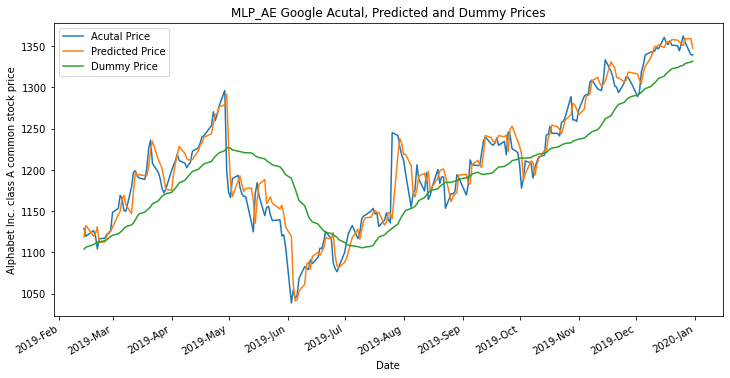

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

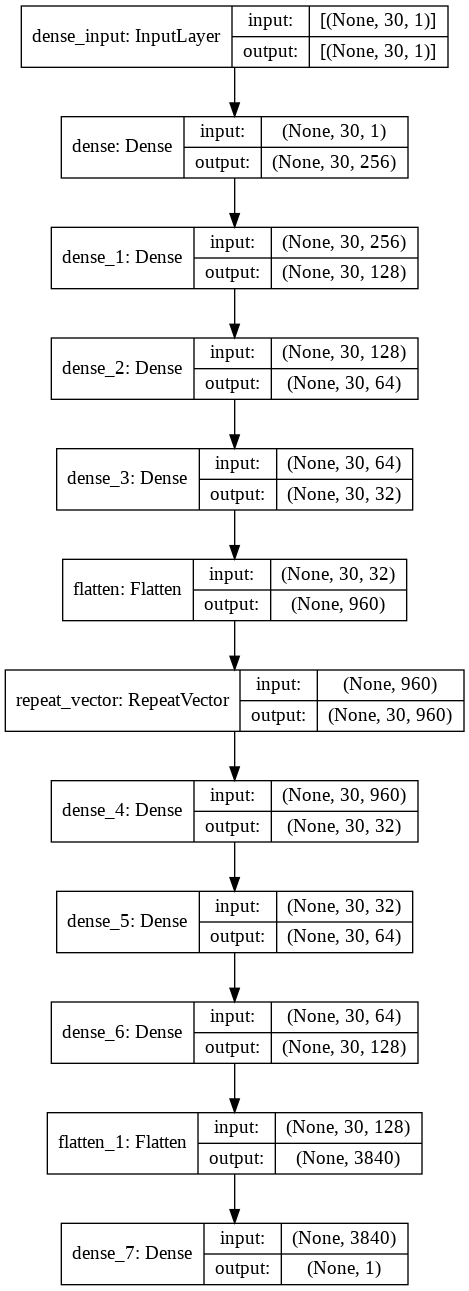

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.004094045056830244
RMSE:  0.06398472518367367
MAE:  0.04528464842676581
Dummy MSE:  0.01786933010743511
Dummy RMSE:  0.13367621369351806
Dummy MAE:  0.10749275974657799


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/MLP_AE_Google/assets
